In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Ver2での変更点

・tf.keras.preprocessing.image.imageDataGeneratorを使用して学習時にデータを水増し(回転、平行移動、マスキング)、バッチごとのデータ読み込み仕様に変更

・参照サイト
https://qiita.com/taichinakabeppu/items/74a27401cae0d0076941


# データ

以下のように、クラスごとに(Langston, ULEクラス)フォルダ分けされている状態から、2. コピー先のフォルダ階層のようにtrain, test階層の下にクラスごとの階層になっているようにデータを振り分けたい。その際、もとの階層でrunoff2.5内では1から順に識別番号がついていて、runoff5.0でも同じように1から順に識別番号がついているので混合されないように新たな名前を割りたい

1 元の階層

* image
    * Langston
        * runoff2.5
            * sample1
            * sample2
        * runoff5.0 
            * sample1
            * sample2
    * ULE
        * runoff2.5
            * sample1
            * sample2
        * runoff5.0 
            * sample1
            * sample2


2 コピー先のフォルダ階層

* image
    * train
        * Langston
        * ULE
    * test
        * Langston
        * ULE

In [20]:
import os
import shutil

src_dir = r'Z:\miyata\RiverShapeRecognition_exp\test\output' # 元の階層のパス
dest_dir = r'Z:\miyata\RiverShapeRecognition_exp\test\new_image' # 複製先のパス

if not os.path.exists(dest_dir):
    os.mkdir(dest_dir)

if not os.path.exists(os.path.join(dest_dir, 'train')):
    os.mkdir(os.path.join(dest_dir, 'train'))

if not os.path.exists(os.path.join(dest_dir, 'test')):
    os.mkdir(os.path.join(dest_dir, 'test'))

for cls_name in ['Langston', 'ULE']:
    if not os.path.exists(os.path.join(dest_dir, 'train', cls_name)):
        os.mkdir(os.path.join(dest_dir, 'train', cls_name))
    if not os.path.exists(os.path.join(dest_dir, 'test', cls_name)):
        os.mkdir(os.path.join(dest_dir, 'test', cls_name))
    
    for runoff in ['runoff2.5', 'runoff5.0']:
        src_cls_dir = os.path.join(src_dir, cls_name, runoff) # 降水量の階層のパス
        # print(f"srs_cls_dir: {src_cls_dir}")

        # train, testに8:2で分割
        fileNum = len(os.listdir(src_cls_dir))
        trainNum = int(fileNum * 0.8)
        testNum = fileNum - trainNum
        randomList = np.random.permutation(fileNum)
        trainList = randomList[:trainNum]
        testList = randomList[trainNum:]
        
        for i, name in enumerate(os.listdir(src_cls_dir)):
            # print(f"name: {name}")
            if i in testList:
                dst_dir = os.path.join(dest_dir, 'test', cls_name) # コピー先のtestディレクトリのクラスの階層のパス
            else:
                dst_dir = os.path.join(dest_dir, 'train', cls_name) # コピー先のtrainディレクトリのクラスの階層のパス
            
            # print(f"dst_dir: {dst_dir}")
            
            src_path = os.path.join(src_cls_dir, name) # コピー元の画像のパス
            # new_name = f'{cls_name}_{runoff}_{name}' # クラス名_降水量_元ファイル名で構成される新しいファイル名
            new_name = name
            os.rename(src_path, os.path.join(src_cls_dir, new_name)) # コピー元のファイル名を変更
            src_path = os.path.join(src_cls_dir, new_name) # コピー元の画像のパス
            dst_path = os.path.join(dst_dir, new_name) # コピー先の画像のパス
            # print(f"src_path: {src_path}")
            # print(f"dst_path: {dst_path}")
            shutil.copyfile(src_path, dst_path) # コピー元の画像をコピー先にコピー

# CNN

## ImageDataGenerator

In [29]:
datagen = ImageDataGenerator(
    rescale=1./255, # 画素値を0-1に変換
    validation_split=0.2, # 20%を検証用に使用
    height_shift_range=0.4, # 40%の範囲で上下にシフト
    width_shift_range=0.4, # 40%の範囲で左右にシフト
    rotation_range=180, # 180度まで回転
    # horizontal_flip=True, # 水平方向に反転
    # vertical_flip=True # 垂直方向に反転
    )

### 画像データの読み込み

In [33]:
batch_size=10
save_augentation_dir = r'Z:\miyata\RiverShapeRecognition_exp\test\augentation\train\Langston'

if not os.path.exists(save_augentation_dir):
    os.makedirs(save_augentation_dir)

train_generator = datagen.flow_from_directory(
    r'Z:\miyata\RiverShapeRecognition_exp\test\new_image\train',
    target_size=(166, 150),
    class_mode='binary',
    batch_size=batch_size,
    subset='training',
    save_to_dir=save_augentation_dir,
)

validation_generator = datagen.flow_from_directory(
    r'Z:\miyata\RiverShapeRecognition_exp\test\new_image\train',
    target_size=(166, 150),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation'
)

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [34]:
# train 画像データ
print("train 画像データ")
print(train_generator.image_shape)

# train ラベル
print("train_generator.class_indices")
print(train_generator.class_indices)

# train 全てのラベル
print("train_generator.classes")
print(train_generator.classes)

train 画像データ
(166, 150, 3)
train_generator.class_indices
{'Langston': 0, 'ULE': 1}
train_generator.classes
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


[1. 1. 0. 0. 1. 1. 0. 1. 0. 1.]


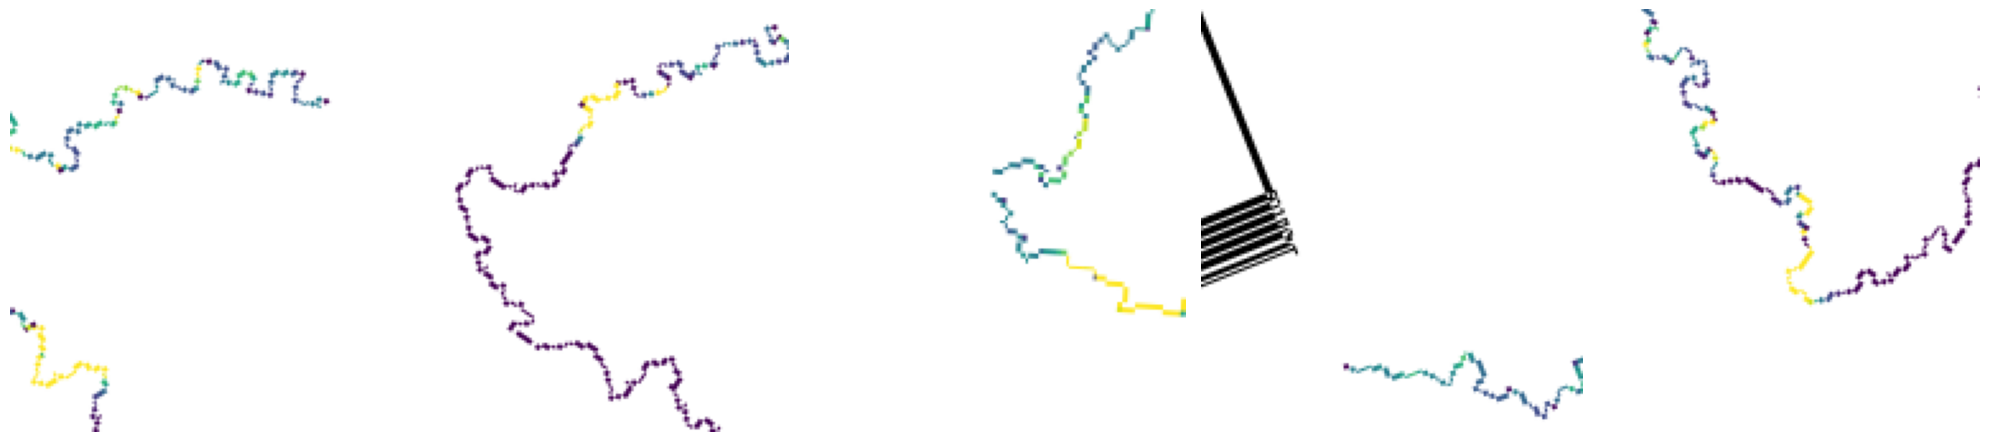

In [32]:
training_images, training_labels = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print(training_labels)
plotImages(training_images[:5])




## CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

# 畳み込み層1  
model.add(layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(504, 448, 4)))
model.add(layers.MaxPool2D(2, 2))

# 畳み込み層2
model.add(layers.Conv2D(64, kernel_size=3, activation='relu')) 
model.add(layers.MaxPool2D(2, 2))

# 全結合層
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))

# 出力層
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# チェックポイントの作成
# 検証セットで最高性能を達成したモデルを保存する
# 保存先は./testmodel
dirpath = "./testmodel"
if not os.path.exists(dirpath):
    os.mkdir(dirpath)
filepath = os.path.join(dirpath, "channelrecog.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True)

# 早期打ち切り
# 10エポック連続で検証セットで性能が向上しなければ、学習を打ち切る
ealystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, ealystopping_cb],
)

# 学習曲線をプロットする
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    r'Z:\miyata\RiverShapeRecognition_exp\test\new_image\test',
    target_size=(166, 150),
    class_mode='binary',
    batch_size=batch_size
)

model.evaluate(test_generator)